In [1]:
import torch as tc
tc.set_default_tensor_type(tc.DoubleTensor)

In [2]:
from __future__ import division
import sys, platform, os

import numpy as np
import scipy as sp
from scipy.optimize import root

# import MyHyperSphericaljl as jl
# import MyOtherFunctions as fun

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.4 installed at /opt/anaconda3/envs/py38/lib/python3.8/site-packages/camb


In [4]:
h = 0.673
ns = 0.966
As = 2e-9
ks = 0.05 # 1/Mpc
c_light = 2.99792458e5 # km/s
l_max = 2000

In [5]:
beta_flat = np.hstack([10**np.linspace(-5, -2, 1500, endpoint=False), np.arange(1e-2, 8e-1, 1e-4)])
beta_open = np.hstack([10**np.linspace(-8, -6, 1000, endpoint=False), 10**np.linspace(-6, -2, 2000, endpoint=False), np.arange(1e-2, 8e-1, 1e-4)])
nu_closed = np.arange(3, 14000, 1)

OmegaK_open = 0.05
Kscale_open = np.sqrt(np.abs((h*100/c_light)**2 * OmegaK_open)) # 1/Mpc
k_open = np.sqrt(beta_open**2 + Kscale_open**2)

OmegaK_closed = -0.05
Kscale_closed = np.sqrt(np.abs((h*100/c_light)**2 * OmegaK_closed)) # 1/Mpc
k_closed = Kscale_closed * np.sqrt(nu_closed**2 - 1)


k_flat = tc.tensor(beta_flat)
k_open = tc.tensor(k_open)
k_closed = tc.tensor(k_closed)
k_array = [k_flat, k_open, k_closed]

beta_flat = tc.tensor(beta_flat)
beta_open = tc.tensor(beta_open)
beta_closed = tc.tensor(nu_closed * Kscale_closed)
beta_array = [beta_flat, beta_open, beta_closed]

l_array = tc.arange(l_max)

In [6]:
def My_Integral(x, y, s):
    '''
        s=True      trapzoidal
        s=False     summation
    '''
    if s:
        dx = x[1:] - x[:-1]
        ymean = (y[:, 1:] + y[:, :-1]) / 2
        return tc.sum(dx * ymean, dim=(1))
    else:
        return tc.sum(tc.ones_like(x) * y * Kscale_closed, dim=(1))

In [7]:
geometry = ['flat', 'open', 'closed']
gamma_GW = 1.8

Total_l = tc.empty([3, l_max])
SW_l = tc.empty([3, l_max])
ISW_l = tc.empty([3, l_max])
slist = [True, True, False]

for i in range(3):
    g = geometry[i]
    jl_SW = tc.tensor(np.load('HyperSpherical_jl_' + g + '.npy'))
    Tl_ISW = 2 * tc.tensor(np.load('Tl_l2000_' + g + '.npy'))

    if i==1:
        jl_SW_qsmall = tc.tensor(np.load('HyperSpherical_jl_open_qsmall.npy'))
        Tl_ISW_qsmall = 2 * tc.tensor(np.load('Tl_l2000_open_qsmall.npy'))

        jl_SW = tc.vstack([jl_SW_qsmall, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_qsmall, Tl_ISW])
    if i==2 :
        jl_SW_beta34 = tc.tensor(np.load('HyperSpherical_jl_closed_beta34.npy'))
        Tl_ISW_beta34 = 2 * tc.tensor(np.load('Tl_l2000_closed_beta34.npy'))

        jl_SW = tc.vstack([jl_SW_beta34, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_beta34, Tl_ISW])
    
    print('The number of modes with ' + g + ' is ', len(jl_SW))

    T_SW = l_array * (l_array + 1) * jl_SW**2
    T_SW = T_SW.T * (k_array[i]**(ns - 3)) * beta_array[i]
    T_SW = (1 - 4/(4 - gamma_GW))**2 * T_SW

    T_ISW = l_array * (l_array + 1) * Tl_ISW**2
    T_ISW = T_ISW.T * (k_array[i]**(ns - 3)) * beta_array[i]

    T_tot = ((1 - 4/(4 - gamma_GW))) * jl_SW + Tl_ISW
    T_tot = l_array * (l_array + 1) * T_tot**2
    T_tot = T_tot.T * (k_array[i]**(ns - 3)) * beta_array[i]

    Dl_SW = My_Integral(beta_array[i], T_SW, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 
    Dl_ISW = My_Integral(beta_array[i], T_ISW, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 
    Dl_tot = My_Integral(beta_array[i], T_tot, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 

    SW_l[i] = Dl_SW
    ISW_l[i] = Dl_ISW
    Total_l[i] = Dl_tot

The number of modes with flat is  9400
The number of modes with open is  10900
The number of modes with closed is  13997


In [8]:
pars_flat = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, 
                            omk=0, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)
pars_open = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, 
                            omk=OmegaK_open, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)
pars_closed = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, 
                            omk=OmegaK_closed, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)

pars_set = [pars_flat, pars_open, pars_closed]
q_start = np.array([0, 0, 2], dtype='int32')

l_array_list = []
Dl_cross = []

for i in range(3):

    #########################################################
    # 1. Computing transfer function for GWB

    g = geometry[i]
    jl_SW = tc.tensor(np.load('HyperSpherical_jl_' + g + '.npy'))
    Tl_ISW = 2 * tc.tensor(np.load('Tl_l2000_' + g + '.npy'))

    if i==1:
        jl_SW_qsmall = tc.tensor(np.load('HyperSpherical_jl_open_qsmall.npy'))
        Tl_ISW_qsmall = 2 * tc.tensor(np.load('Tl_l2000_open_qsmall.npy'))

        jl_SW = tc.vstack([jl_SW_qsmall, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_qsmall, Tl_ISW])

    if i==2 :
        jl_SW_beta34 = tc.tensor(np.load('HyperSpherical_jl_closed_beta34.npy'))
        Tl_ISW_beta34 = 2 * tc.tensor(np.load('Tl_l2000_closed_beta34.npy'))

        jl_SW = tc.vstack([jl_SW_beta34, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_beta34, Tl_ISW])
    
    print('The number of modes with ' + g + ' is ', len(jl_SW))

    # T_SW = l_array * (l_array + 1) * jl_SW
    # T_SW = (1 - 2/(4 - gamma_GW)) * T_SW.T * (k_array[i]**(ns - 3)) * beta_array[i]

    # T_ISW = l_array * (l_array + 1) * Tl_ISW
    # T_ISW = T_ISW.T * (k_array[i]**(ns - 3)) * beta_array[i]

    T_tot = ((1 - 4/(4 - gamma_GW))) * jl_SW + Tl_ISW
    T_tot = l_array * (l_array + 1) * T_tot
    T_tot = T_tot.T * (k_array[i]**(ns - 3)) * beta_array[i]

    #########################################################
    # 2. Computing transfer function for CMB

    pars = pars_set[i]
    res = camb.get_transfer_functions(pars)
    res.calc_transfers(pars)
    CMB_transfer = res.get_cmb_transfer_data().get_transfer()

    L_list = CMB_transfer[0]
    print('The last 5 l modes are: ', L_list[-6:-1])
    L_list = L_list[:-4]
    q_list = CMB_transfer[1]
    q_list = q_list[q_start[i]:]
    TCMB_list = CMB_transfer[2]
    TCMB_list = TCMB_list[:-4, q_start[i]:]
    # print(CMB_transfer[0])

    #########################################################
    # 3. Interpolation

    TGWB_list = tc.empty(TCMB_list.shape)
    for il in range(len(L_list)):
        L = L_list[il]
        TGWB_list[il] = tc.tensor(np.interp(q_list, beta_array[i], T_tot[L]))
    
    T_cross = - TGWB_list * tc.tensor(TCMB_list)

    Dl_cross_tot = My_Integral(tc.tensor(q_list), T_cross, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi
    
    l_array_list.append(L_list)
    Dl_cross.append(Dl_cross_tot)

The number of modes with flat is  9400
The last 5 l modes are:  [1900 1950 2000 2050 2100]
The number of modes with open is  10900
The last 5 l modes are:  [1884 1938 1992 2046 2098]
The number of modes with closed is  13997
The last 5 l modes are:  [1938 1984 2030 2076 2113]


In [9]:
lplot = tc.arange(2, 1939)

yflatfun = sp.interpolate.interp1d(l_array_list[0], Dl_cross[0], kind='cubic')
yopenfun = sp.interpolate.interp1d(l_array_list[1], Dl_cross[1], kind='cubic')
yclosedfun = sp.interpolate.interp1d(l_array_list[2], Dl_cross[2], kind='cubic')

y_flat = tc.tensor(yflatfun(lplot))
y_open = tc.tensor(yopenfun(lplot))
y_closed = tc.tensor(yclosedfun(lplot))

In [10]:
np.save('PTGWB_CMB_cross.npy', np.array([y_flat, y_open, y_closed]))

/var/folders/j8/mz7l4_197pn37cbb5wq5lgw40000gn/T/ipykernel_85710/2091175058.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save('PTGWB_CMB_cross.npy', np.array([y_flat, y_open, y_closed]))
/var/folders/j8/mz7l4_197pn37cbb5wq5lgw40000gn/T/ipykernel_85710/2091175058.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('PTGWB_CMB_cross.npy', np.array([y_

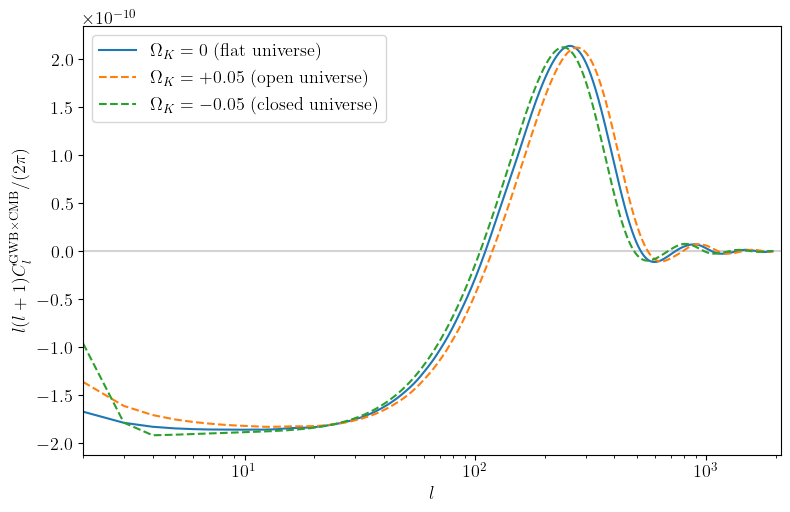

In [10]:
fig = plt.figure(figsize=(9, 5.5623))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 13,
})

plt.hlines([0], xmin=0, xmax=2500, colors='lightgray')
plt.plot(lplot, y_flat, '-', label=r'$\Omega_K=0$ (flat universe)')
plt.plot(lplot, y_open, '--', label=r'$\Omega_K=+0.05$ (open universe)')
plt.plot(lplot, y_closed, '--', label=r'$\Omega_K=-0.05$ (closed universe)')
# plt.plot(l_array_list[0], Dl_cross[0], '.', c='#1f77b4')#, label=r'$\Omega_K=0$ (flat universe)')
# plt.plot(l_array_list[1], Dl_cross[1], '.', c='#ff7f0e')#, label=r'$\Omega_K=+0.05$ (open universe)')
# plt.plot(l_array_list[2], Dl_cross[2], '.', c='#2ca02c')#, label=r'$\Omega_K=-0.05$ (closed universe)')


plt.xscale('log')
plt.xlim([2,2100])

plt.xlabel(r'$l$', usetex=True)
plt.ylabel(r'$l(l+1)C_l^{\mathrm{GWB}\times\mathrm{CMB}} / (2\pi)$', usetex=True)
plt.legend(loc="best")

plt.savefig('cross_correlation_FOPT.pdf')

plt.show()